In [1]:
import os 
import numpy as np

# 返回目录中所有图像的文件名列表
def get_imlist(path):
    return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]

In [2]:
get_imlist(r'E:\digital_image_process\images')

['E:\\digital_image_process\\images\\1.jpg',
 'E:\\digital_image_process\\images\\2.jpg',
 'E:\\digital_image_process\\images\\3.jpg',
 'E:\\digital_image_process\\images\\4.jpg',
 'E:\\digital_image_process\\images\\5.jpg',
 'E:\\digital_image_process\\images\\6.jpg',
 'E:\\digital_image_process\\images\\7.jpg',
 'E:\\digital_image_process\\images\\8.jpg',
 'E:\\digital_image_process\\images\\cameraman.jpg',
 'E:\\digital_image_process\\images\\test.jpg']

### 直方图均衡化

In [3]:
from PIL import Image
from numpy import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # mpimg 用于读取图片
def histeq(im, nbr_bins=256):
    # 计算图像的直方图
    imhist, bins = histogram(im.flatten(), nbr_bins)
    # 计算累计分布函数
    cdf = imhist.cumsum()
    
    # 归一化
    cdf = 255 * cdf / cdf[-1]
    
    # 使用累计分布函数的线性插值，计算新的像素值
    im2 = interp(im.flatten(), bins[:-1], cdf)
    
    return im2.reshape(im.shape), cdf

In [4]:
src_im = np.array(mpimg.imread('E:\\digital_image_process\\images\\1.jpg'))
gray_im = np.array(Image.open('E:\\digital_image_process\\images\\1.jpg').convert('L'))
im1, cdf = histeq(gray_im)

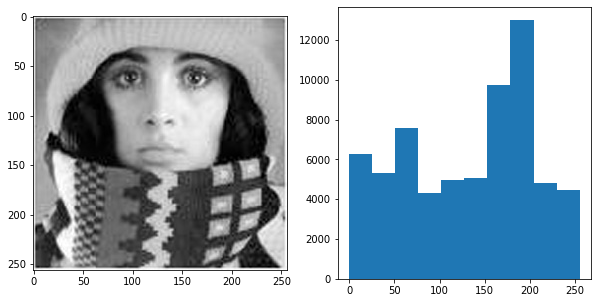

In [5]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
ax.imshow(src_im)
ax = plt.subplot(1,2,2)
ax.hist(gray_im.flatten())
plt.show()

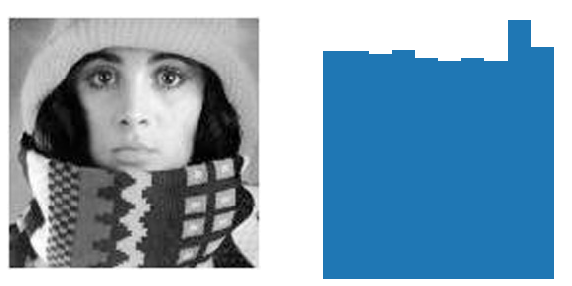

In [6]:
plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)
ax.imshow(src_im)
plt.axis('off')
ax = plt.subplot(1,2,2)
ax.hist(im1.flatten())
plt.axis('off')
plt.show()

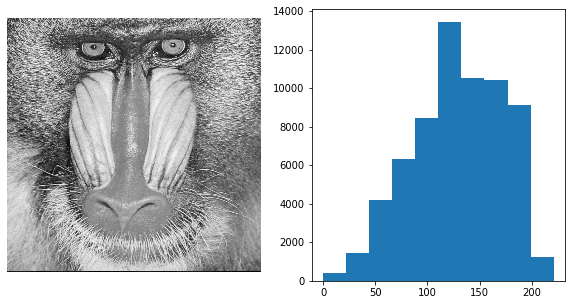

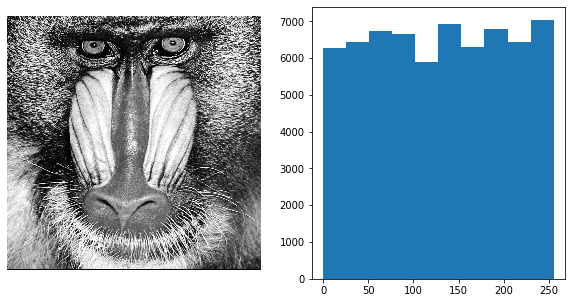

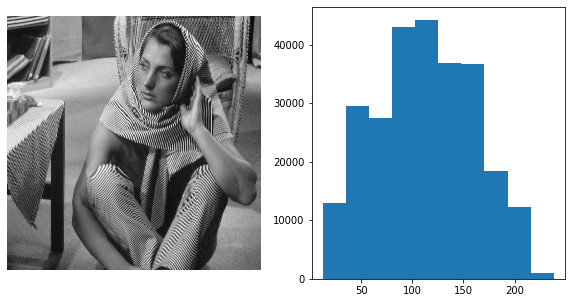

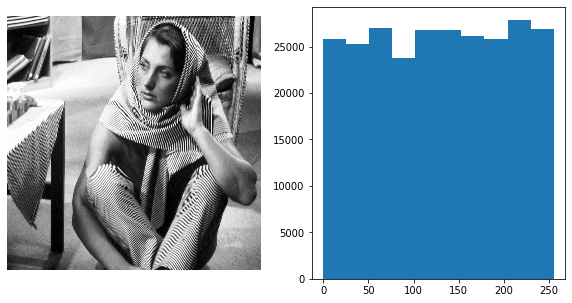

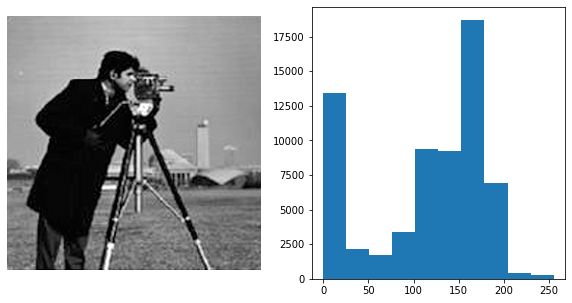

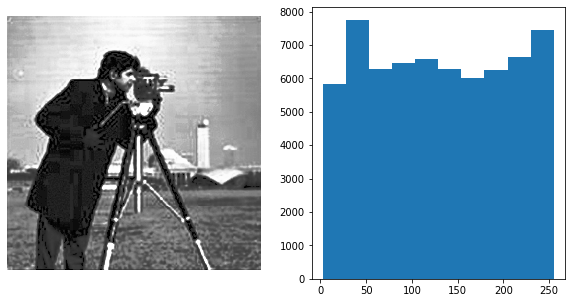

In [7]:
for index in get_imlist(r'E:\digital_image_process\images')[3:6]:
#     src_im = np.array(Image.open(index))
    gray_im = np.array(Image.open(index).convert('L'))
    # 直方图均衡化
    out_im, cdf = histeq(gray_im)
    # 原图信息
    plt.figure(figsize=(10,5))
    ax = plt.subplot(1,2,1)
    # 不加cmap会显示错误
    plt.axis('off')
    ax.imshow(gray_im, cmap='gray')
    ax = plt.subplot(1,2,2)
    ax.hist(gray_im.flatten())
    plt.savefig("work1_result\\" + index.split('\\')[-1].split('.')[0] + '_src.jpg')
    # 变换后的信息
    plt.figure(figsize=(10,5))
    ax = plt.subplot(1,2,1)
    plt.axis('off')
    ax.imshow(out_im,cmap='gray')
    ax = plt.subplot(1,2,2)
    ax.hist(out_im.flatten())
    plt.savefig("work1_result\\" + index.split('\\')[-1].split('.')[0] + '_hist.jpg')

In [8]:
index = get_imlist(r'E:\digital_image_process\images')
i = index[0].split('\\')[-1].split('.')[0] + '_hist.jpg'
i

'1_hist.jpg'

In [9]:
for index in get_imlist(r'E:\digital_image_process\images')[:3]:
    print(index)

E:\digital_image_process\images\1.jpg
E:\digital_image_process\images\2.jpg
E:\digital_image_process\images\3.jpg


## 对彩色图像的直方图均衡化

In [10]:
import cv2
def RGB2HSI(rgb_img):
    """
    这是将RGB彩色图像转化为HSI图像的函数
    :param rgm_img: RGB彩色图像
    :return: HSI图像
    """
    #保存原始图像的行列数
    row = np.shape(rgb_img)[0]
    col = np.shape(rgb_img)[1]
    #对原始图像进行复制
    hsi_img = rgb_img.copy()
    #对图像进行通道拆分
    B,G,R = cv2.split(rgb_img)
    #把通道归一化到[0,1]
    [B,G,R] = [ i/ 255.0 for i in ([B,G,R])]
    H = np.zeros((row, col))    #定义H通道
    I = (R + G + B) / 3.0       #计算I通道
    S = np.zeros((row,col))      #定义S通道
    for i in range(row):
        den = np.sqrt((R[i]-G[i])**2+(R[i]-B[i])*(G[i]-B[i]))
        thetha = np.arccos(0.5*(R[i]-B[i]+R[i]-G[i])/den)   #计算夹角
        h = np.zeros(col)               #定义临时数组
        #den>0且G>=B的元素h赋值为thetha
        h[B[i]<=G[i]] = thetha[B[i]<=G[i]]
        #den>0且G<=B的元素h赋值为thetha
        h[G[i]<B[i]] = 2*np.pi-thetha[G[i]<B[i]]
        #den<0的元素h赋值为0
        h[den == 0] = 0
        H[i] = h/(2*np.pi)      #弧度化后赋值给H通道
    #计算S通道
    for i in range(row):
        min = []
        #找出每组RGB值的最小值
        for j in range(col):
            arr = [B[i][j],G[i][j],R[i][j]]
            min.append(np.min(arr))
        min = np.array(min)
        #计算S通道
        S[i] = 1 - min*3/(R[i]+B[i]+G[i])
        #I为0的值直接赋值0
        S[i][R[i]+B[i]+G[i] == 0] = 0
    #扩充到255以方便显示，一般H分量在[0,2pi]之间，S和I在[0,1]之间
    hsi_img[:,:,0] = H*255
    hsi_img[:,:,1] = S*255
    hsi_img[:,:,2] = I*255
    return hsi_img

def HSI2RGB(hsi_img):
    """
    这是将HSI图像转化为RGB图像的函数
    :param hsi_img: HSI彩色图像
    :return: RGB图像
    """
    # 保存原始图像的行列数
    row = np.shape(hsi_img)[0]
    col = np.shape(hsi_img)[1]
    #对原始图像进行复制
    rgb_img = hsi_img.copy()
    #对图像进行通道拆分
    H,S,I = cv2.split(hsi_img)
    #把通道归一化到[0,1]
    [H,S,I] = [ i/ 255.0 for i in ([H,S,I])]
    R,G,B = H,S,I
    for i in range(row):
        h = H[i]*2*np.pi
        #H大于等于0小于120度时
        a1 = h >=0
        a2 = h < 2*np.pi/3
        a = a1 & a2         #第一种情况的花式索引
        tmp = np.cos(np.pi / 3 - h)
        b = I[i] * (1 - S[i])
        r = I[i]*(1+S[i]*np.cos(h)/tmp)
        g = 3*I[i]-r-b
        B[i][a] = b[a]
        R[i][a] = r[a]
        G[i][a] = g[a]
        #H大于等于120度小于240度
        a1 = h >= 2*np.pi/3
        a2 = h < 4*np.pi/3
        a = a1 & a2         #第二种情况的花式索引
        tmp = np.cos(np.pi - h)
        r = I[i] * (1 - S[i])
        g = I[i]*(1+S[i]*np.cos(h-2*np.pi/3)/tmp)
        b = 3 * I[i] - r - g
        R[i][a] = r[a]
        G[i][a] = g[a]
        B[i][a] = b[a]
        #H大于等于240度小于360度
        a1 = h >= 4 * np.pi / 3
        a2 = h < 2 * np.pi
        a = a1 & a2             #第三种情况的花式索引
        tmp = np.cos(5 * np.pi / 3 - h)
        g = I[i] * (1-S[i])
        b = I[i]*(1+S[i]*np.cos(h-4*np.pi/3)/tmp)
        r = 3 * I[i] - g - b
        B[i][a] = b[a]
        G[i][a] = g[a]
        R[i][a] = r[a]
    rgb_img[:,:,0] = B*255
    rgb_img[:,:,1] = G*255
    rgb_img[:,:,2] = R*255
    return rgb_img

In [11]:
import os
 
def mkdir(path):
 
    folder = os.path.exists(path)
 
    if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(path)            #makedirs 创建文件时如果路径不存在会创建这个路径
        print("---  new folder...  ---" + path) 
        print("---  OK  ---")

    else:
        print("---  There is this folder!  ---" + path)

file = "E:\\digital_image_process\\work2_result\\" + index[0].split('\\')[-1].split('.')[0]
file
mkdir(file)             #调用函数

---  new folder...  ---E:\digital_image_process\work2_result\E
---  OK  ---


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


---  There is this folder!  ---E:\digital_image_process\work2_result\12&9
---  new folder...  ---E:\digital_image_process\work2_result\flower
---  OK  ---
---  new folder...  ---E:\digital_image_process\work2_result\Lena
---  OK  ---


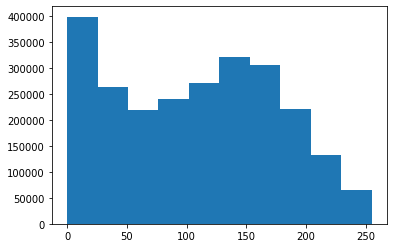

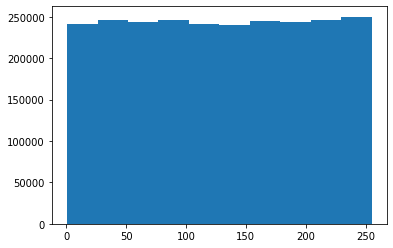

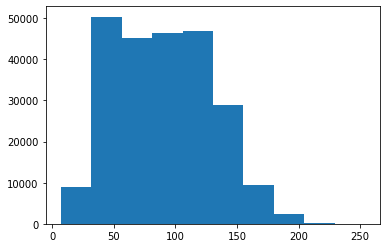

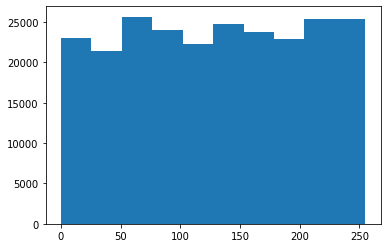

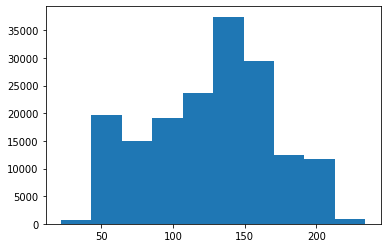

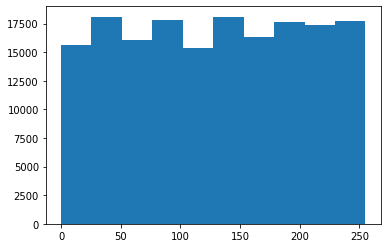

In [16]:
# 遍历文件夹 读出彩色图片
index = get_imlist("E:\\digital_image_process\\color_images")
for i in index:
    image = cv2.imread(i)
#     print(image)
    # 将RGB转为HSI
    hsi_img = RGB2HSI(image)
    # 将I通道直方图直方图均衡化
    hsi_i = cv2.split(hsi_img)[-1]
    hsieq, _ = histeq(hsi_i, nbr_bins=255)
    # 原图的直方图
    plt.figure()
    plt.hist(hsi_i.flatten())
    #     plt.show()
    img_name = i.split('\\')[-1].split('.')[0]
    file = "E:\\digital_image_process\\work2_result\\" + img_name
    mkdir(file)  
    plt.savefig(file + '\\' + 'hist.jpg')
    # 均衡化后的直方图
    plt.figure()
    plt.hist(hsieq.flatten())
    plt.savefig(file+ '\\' + 'histeq.jpg')
    # 将HSI转为RGB
    # 将图片的I通道替换为新计算的I
    hsi_img[:,:, -1] = hsieq
    # 输出图片
    hsi_trans = HSI2RGB(hsi_img)
    cv2.imwrite(file+ '\\' + "hsi2rgb.jpg", hsi_trans)